<a href="https://colab.research.google.com/github/saranpan/ECG-Heartbeat-classifier/blob/main/ar_classification/Arrhythmia_train_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Hardware will be used on this notebook

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-43ee859f-bd6b-75da-fd03-e374193a0330)


# 🌏 Business Understanding

The healthcare industry is rapidly growing, with the integration of various technologies to help ease the burden on doctors and improve patient outcomes. One technology that stands out is the electrocardiogram (ECG), which is highly effective in checking the electrical activity and rhythm of the heart. By generating a graph of the heart's electrical activity over time, an ECG can accurately detect arrhythmias (หัวใจเต้นผิดจังหวะ). However, not all doctors can diagnose arrhythmias with high accuracy, and real-time diagnosis is challenging given that heart diseases can happen at any time.

Arrhythmia is a medical condition characterized by an irregular heartbeat, which can lead to the heart beating too fast, too slow, or with an irregular rhythm. This can result in insufficient blood pumping to the body and cause symptoms such as dizziness, fainting, or related issues. Real-time detection of arrhythmia can significantly improve patient outcomes, but this requires automation with intelligent doctors.

To address this issue, our goal is to launch a product for the healthcare industry that uses AI to solve the problem. We will utilize ECG signals to predict the type of arrhythmia and classify irregular heartbeats accurately to determine the appropriate treatment for the patient.


# 📰 Data Understanding


</fieldset>

The main objective of this project is to develop a machine learning approach that can detect and diagnose Arrhythmia at an early stage, using ECG heartbeat signals as input. To achieve this, we aim to train the AI to classify the type of Arrhythmia, limiting our scope to five categories:

| Key | Category | Annotations |
| --- | --- | --- |
| 0 | N | Normal |
| 1 | S | Supra-ventricular premature |
| 2 | V | Ventricular escape |
| 3 | F | Fusion of ventricular and normal |
| 4| Q | Unclassifiable |


The inclusion of the "Unclassifiable" category is to allow for further diagnosis of patients whose Arrhythmia type is not immediately recognized.

To evaluate the performance of the machine learning model, we will use its ability to accurately classify Arrhythmia types. We will use the weighted F1 score as the criterion for selecting the best model. For training the model, we will use a labeled dataset of ECG heartbeat signals and corresponding Arrhythmia classifications. Once trained, the model will be able to predict the type of Arrhythmia for new ECG heartbeat signals, thus aiding in the early detection and diagnosis of Arrhythmia.

In summary, the goal of this project is to accurately classify the type of Arrhythmia by mapping a sequence of ECG heartbeat signals into one of five different categories. The table above shows the categories we will use to classify Arrhythmia, with the performance of the machine learning model being evaluated using the weighted F1 score.


</fieldset>

To develop a machine learning model for ECG analysis, and satisfy the data needed condition which discussed on Data Understanding section, we needed to collect a dataset with ECG heartbeat signals as predictors and mult-labels indicating the various of heart arrhythmia as the target. One such dataset we found on [Kaggle](https://www.kaggle.com/datasets/shayanfazeli/heartbeat) was scraped from a [research paper](https://arxiv.org/abs/1805.00794) , which in turn was scraped from the [MIT-BIH Arrhythmia Database](https://www.physionet.org/content/mitdb/1.0.0/). However, the dataset was downsampled, resulting in a reduced number of rows. It is important to note that the trained model cannot be applied universally as it has limitations arising from the dataset used to train it. Therefore, it is worth reviewing some metadata of the MIT-BIH Arrhythmia Database, which we used to train the model.

The summary of the limitations of this dataset are as follows:

The limitations of the MIT-BIH Arrhythmia Database include:

> Limited Sample Size: The database contains only 48 half-hour excerpts of ECG recordings from 47 subjects, which might not be enough to represent the full diversity of arrhythmias in a larger population.

> Outdated Data: The ECG recordings were obtained between 1975 and 1979. Advances in recording technology, treatment, and demographic changes since then may affect the applicability of the dataset to current clinical practice.

> Lack of demographic information: The dataset does not provide detailed demographic information about the subjects, such as age, gender, ethnicity, or medical history, which could be essential for understanding the variations in ECG signals and arrhythmias.

> Imbalanced Data: The dataset was selected to include less common but clinically significant arrhythmias, which might result in an imbalanced dataset that could affect the performance of machine learning models.

> Digitization Limitations: The recordings were digitized at 360 samples per second per channel with an 11-bit resolution. While this resolution is adequate for most purposes, it may not be sufficient for detecting subtle variations in ECG signals.

> Annotation Disagreements: Although two or more cardiologists independently annotated each record, and disagreements were resolved to obtain the reference annotations, the possibility of human error or subjectivity in the annotations cannot be ruled out.

Despite these limitations, the MIT-BIH Arrhythmia Database has been widely used in research and has contributed to the development of numerous arrhythmia detection algorithms.


Moreover, the data from the [MIT-BIH Arrhythmia Database](https://www.physionet.org/content/mitdb/1.0.0/) is not exactly the same used for modeling in the [research paper](https://arxiv.org/abs/1805.00794), the author of paper have preprocessed in the following steps

1. Splitting the continuous ECG signal to 10s windows and select a 10s window from an ECG signal. 

2. Normalizing the amplitude values to the range of between zero and one. 

3. Finding the set of all local maximums based on zerocrossings of the first derivative. 

4. Finding the set of ECG R-peak candidates by applying a threshold of 0.9 on the normalized value of the local maximums. 

5. Finding the median of R-R time intervals as the nominal heartbeat period of that window (T). 

6. For each R-peak, selecting a signal part with the length equal to 1.2T. 

7. Padding each selected part with zeros to make its length equal to a predefined fixed length.

The size of the whole dataset is approximately 100,000 rows, That is an overview of the metadata for this dataset. Moving forward, we will import the dataset and conduct exploratory analysis to gain a more comprehensive understanding of its contents.

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import math
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

print('setup libraries completed')

setup libraries completed


## Import Arrhythmia Data 

Via kaggle API

In [ ]:
%%capture
!pip install kora kaggle 

In [ ]:
from kora import kaggle
import pandas as pd
from sklearn.model_selection import train_test_split

def import_kaggle_dataset():
    # If failed, download Kaggle API to your drive first
    kaggle.download('shayanfazeli/heartbeat')
    print('The Kaggle Dataset was downloaded into your directory')

def create_arrhythmia_dataset():
    train = pd.read_csv('/content/mitbih_train.csv', header=None)
    test = pd.read_csv('/content/mitbih_test.csv', header=None)
    return train, test

def check_null(df):
    if df.isnull().values.any():
        print("The dataset contains null values")
    else:
        print("The dataset contains NO null values")

def get_proportion_train_test(train,test):
    total = len(train) + len(test)

    train_prop = len(train) / total 
    test_prop = len(test) / total 

    return f'train:test proportion = {train_prop:.2f} : {test_prop:.2f}'

In [ ]:
import_kaggle_dataset()
#  <- Check the data files in your directory
train, test = create_arrhythmia_dataset()

 89% 88.0M/98.8M [00:00<00:00, 167MB/s]
100% 98.8M/98.8M [00:00<00:00, 150MB/s]
The Kaggle Dataset was downloaded into your directory


In [ ]:
print( f' Arrhythmia : {get_proportion_train_test(train,test)}' )

 Arrhythmia : train:test proportion = 0.80 : 0.20


In [ ]:
# Check null
check_null(train)
check_null(test)

The dataset contains NO null values
The dataset contains NO null values


In [ ]:
# Originally, Only train and test dataset were already splitted by kaggle, 
# we need to further split train into train and val where the size is equal to test
# goal : train-test : 80-20 into train-val-test : 60-20-20
# since 25% of 80% is 20%, hence, we will split the train into train-val by 75:25

seed = 42
train, val = train_test_split(train, test_size=0.25, random_state=seed, stratify=train[187])

## Simple EDA

- check the distribution of type of Arrhythmia for train/test set
- visualize the ecg heartbeat signal 

In [ ]:
import plotly.graph_objects as go

def plot_class(train,test,title='Value counts for each class of ..'):
    # Create a bar plot for train and test set for each class
    train_value_counts = train[187].value_counts()
    test_value_counts = test[187].value_counts()

    fig = go.Figure(go.Bar(
                x=train_value_counts.index,
                y=train_value_counts.values,
                text=train_value_counts.values,
                textposition='auto',
                name='Train Set'
            ))
    
    fig.add_trace(go.Bar(
            x=test_value_counts.index,
            y=test_value_counts.values,
            text=test_value_counts.values,
            textposition='auto',
            name='Test Set'
        ))
    
    # Set plot title and axis labels
    fig.update_layout(title=title,
                    xaxis_title="Class",
                    yaxis_title="Count")

    # Display the plot
    fig.show()

In [ ]:
plot_class(train,test, title='Value counts for each class  in train/test set of MLT-BLH dataset')

Clearly, It is imbalanced in targets y. Moreover, the distribution of train and test share the similar proportion of the classes 

The majority of class is Normal (0), and the notable minority class is F (4)

Imbalanced, then what? : If we use the plain loss function (say cross entropy loss function which is the loss for multi-class), it is very likely that the model will optimize the loss by guessing every class as the majority class. This will lead us to carefully choosing the right loss function to prevent undesirable output

According to the paper we obtained the dataset from, the classes we have are shown as the following

Next, we wouldl like to observe the random heartbeat of each class of all types of arrhythmias

In [ ]:
import plotly.express as px

def plot_individual_class(df):

    # randomly sample one row per class
    df_sampled = df.groupby(187).apply(lambda x: x.sample(n=1)).reset_index(drop=True)


    # melt the dataframe to convert it from wide to long format
    df_melted = df_sampled.melt(id_vars=187, var_name='timestep')

    class_names = {0: 'Normal (0)', 1: 'Supra-ventricular premature (1)', 2: 'Ventricular escape (2)', 3: 'Fusion of ventricular (3)', 4: 'Unclassifiable (4)'}

    # replace the class numbers with their corresponding names
    df_melted['class'] = df_melted[187].map(class_names)

    # create the line plot with Plotly
    fig = px.line(df_melted, x='timestep', y='value', color='class')

    # update the layout of the plot
    fig.update_layout(title='1-beat ECG for each category',
                    xaxis_title='Timestep',
                    yaxis_title='Normalized Value')

    # display the plot
    fig.show()

In [ ]:
plot_individual_class(train)

# Re-run to see new random observations for each class 

You can see that not all beats are fully recorded for 187 timesteps, instead they do zero padding.

Next we are going to check the only signal whichhave a full record

In [ ]:
complete = train[train[186] != 0]

print(f'only {len(complete)} beat(s) are fully record for 187 timesteps')

only 583 beat(s) are fully record for 187 timesteps


In [ ]:
plot_individual_class(complete)

In [ ]:
# What's about test set

complete = test[test[186] != 0]

print(f'only {len(complete)} beat(s) are fully record for 187 timesteps')

only 188 beat(s) are fully record for 187 timesteps


In [ ]:
# Beats of Test set 

plot_individual_class(complete)

None of the fusion of ventricular and unclassfier are fully recorded, 

thus, this MIGHT be a pattern the model is learning to classify them as fusion of ventricular and unclassfier if they found the zero padding.

Personally, it might make the model archeive high score in this dataset, but in practical, this is not always the case.

In [ ]:
# No longer used

del complete

# 🔍 Data Preparation

Before doing anything, it's good to set deteministic seed, so, we can reproduce the result

Although, it's not possible to fully reproduce, but we can minimize the variance of the result

In [ ]:
import torch
import random
import numpy as np

# Set up reproducible seed
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

## Data augmentation

Since I'm not currently an domain expert about heartbeat signal, I'm not confident enough to do data augmentation.

If I have more time, i will consider read this paper, so, I will have the idea on data augmentation for heartbeat signal (https://arxiv.org/pdf/2202.00569)

In [ ]:
# Skip

## Torch Dataset

In this notebook, I (Run) decided to use Pytorch Framework, so, we need to transform train, val, test into torch dataset object

In [ ]:
# Pandas to numpy 

X_train = train.values[:, :-1] 
y_train = train.values[:, -1].astype(int)

X_val = val.values[:, :-1]
y_val = val.values[:, -1].astype(int)

X_test = test.values[:, :-1]
y_test = test.values[:, -1].astype(int)

In [ ]:
# Turn to one-hot first
from keras.utils.np_utils import to_categorical

y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

In [ ]:
import os
import torch
from torch.utils.data import Dataset

class Arrhythmias_Dataset(Dataset):
    def __init__(self, X, y, transforms=None):
        assert y.shape[1] == 5
        assert X.shape[1] == 187
        assert X.ndim == 2
        self.X = X
        self.y = y
        self.transforms = transforms
        self._process()

    def _process(self):
        pass

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,index):
        
        X = torch.tensor( self.X[index] , dtype=torch.float32)
        X = X.unsqueeze(0)
        y = torch.tensor( self.y[index] , dtype = torch.float32)#.long()

        if self.transforms:
            X = self.transforms(X)


        return X, y

In [ ]:
# Setup

train_set = Arrhythmias_Dataset(X_train,y_train)
val_set = Arrhythmias_Dataset(X_val,y_val)
test_set = Arrhythmias_Dataset(X_test,y_test)

As well as dataloader, since we decided to do mini-batches GD. in order to overcome the out-of-memory issue in RAM. Batch_size for val_set is arbitrary, but cannot be full-batch size, otherwise, it will be out-of-memory 

Doing Mini-batch also make a set of parameter of the model converges faster, and generalize better than batch GD.

In [ ]:
from torch.utils.data import DataLoader

def get_loader(train_set,val_set,test_set,train_batch_size = 256):
    """
    Return train_loader and val_loader given wandb.config
    !Warning : Make sure to declare p_train, p_val as global variable before

    """
    # Dependence Config : architecture, batch_size, transform

    train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1024, shuffle=False) # Val set should not be fine tuned, since they always give the same score regardless the batch size
    test_loader = DataLoader(test_set, batch_size=1024, shuffle=False) # Val set should not be fine tuned, since they always give the same score regardless the batch size

    return train_loader, val_loader, test_loader

In [ ]:
train_loader, val_loader, test_loader = get_loader(train_set,val_set,test_set,train_batch_size = 256) # Train batch_size

# 👉 Modelling

## Setup all architecture

Although sequence is not arbitrary due to zero padding, but order still need to be preserved, so we will give up on non-sequence model due to bad representation of human intelligence. Hence, all candidates we choose will be the most common architectures that are appropriate with our task; sequence model
However, just one non-sequence model to prove that the order matters

- Logistic regression


I would like to divide categories of architecture into 2 groups: RNN-based and CNN-based

RNN-based is the default choice for sequence data,

- GRU 
- LSTM 

Note that These above architecture can have more than 1 layers

The thing I worry is that the zero padding may reduce the performance of them. In future, If possible, we will mask those zero padding, so, it could show the true performance.

However, CNN with conv1d layer still is able to do so. Moreover, it can be used as transfer learning due to the feature extraction layer. We may transfer them into another task on Myocardial infarction which might suffer from relatively low data 

Due to a limited time, I plan to implement a reliable convolutional neural network (CNN) architecture for our task. We will base our model on a research paper that we obtained the data from, which uses a Conv1d-based architecture with residual blocks.

- Deep_ResCNN

The proposed CNN architecture will have multiple convolutional layers, each with 32 channels, a stride of 5, and same padding. This ensures that the addition in the residual blocks can be performed on units with the same number of channels without having to map them to the same unit using weight dot products. We will incorporate 5 residual connection blocks over the plain convolutional layers, which helps to accelerate learning by addressing the vanishing gradient problem. Finally, we will add three fully connected layers with the ReLU activation function for the hidden layers and softmax for the output layer.



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(187, 5)
        
    def forward(self, x):
        x= x.squeeze(1)
        out = self.linear(x)
        return out

if __name__ == '__main__':
    x = torch.rand(32,1,187)
    # Test 1 layer of GRU with hidden size 32x32
    logistic_model = LogisticRegression()
    out = logistic_model(x)
    print(out.shape)

torch.Size([32, 5])


In [ ]:
import torch.nn as nn

# GRU model # Many-to-one
class GRUModel(nn.Module):
    def __init__(self, hidden_size, num_layers, device = device):
        super(GRUModel,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(1, hidden_size, num_layers, batch_first=True).to(device) # batch_first=True : Optional, but I prefer the first axis of data shape to be batch
        self.fc = nn.Linear(hidden_size,5).to(device)

        self.device = device
    def forward(self, x):
        x = x.permute(0, 2, 1)
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(self.device)
        out, _ = self.gru(x, h0)
        out = out[:,-1,:] # Take only the last timestep of the output layer
        out = self.fc(out)
        return out

if __name__ == '__main__':
    x = torch.rand(32,1,187).to(device)

    # Test 1 layer of GRU with hidden size 32x32
    gru_model = GRUModel(hidden_size=32,num_layers = 1)
    gru_model2 = GRUModel(hidden_size=32,num_layers = 2)
    out = gru_model(x)
    out2 = gru_model2(x)
    print(out.shape)
    print(out2.shape)

torch.Size([32, 5])
torch.Size([32, 5])


In [ ]:
# LSTM model # Many-to-one
class LSTMModel(nn.Module):
    def __init__(self, hidden_size, num_layers, device = device):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(1, hidden_size, num_layers, batch_first=True).to(device) # batch_first=True : Optional, but I prefer the first axis of data shape to be batch
        self.fc = nn.Linear(hidden_size,5).to(device)

    def forward(self, x):

        x = x.permute(0, 2, 1)
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device) #short term
        c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device) #long term

        out, _ = self.lstm(x, (h0,c0))
        out = out[:,-1,:] # Take only the last timestep of the output layer
        out = self.fc(out)
        return out

if __name__ == '__main__':
    x = torch.rand(32,1,187).to(device)

    # Test 1 layer of GRU with hidden size 32x32
    lstm_model = LSTMModel(hidden_size=32,num_layers = 1)
    lstm_model2 = LSTMModel(hidden_size=32,num_layers = 2)
    out = lstm_model(x)
    out2 = lstm_model2(x)
    print(out.shape)
    print(out2.shape)

torch.Size([32, 5])
torch.Size([32, 5])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Deep_ResCNN(nn.Module):
    def __init__(self):
        super(Deep_ResCNN, self).__init__()
        # kernel size : (5,), number of channel : 32
        self.conv1 = nn.Conv1d(1, 32, 5)
        
        self.conv2_1 = nn.Conv1d(32, 32, 5, padding=2)
        self.conv2_2 = nn.Conv1d(32, 32, 5, padding=2)
        
        self.conv3_1 = nn.Conv1d(32, 32, 5, padding=2)
        self.conv3_2 = nn.Conv1d(32, 32, 5, padding=2)
        
        self.conv4_1 = nn.Conv1d(32, 32, 5, padding=2)
        self.conv4_2 = nn.Conv1d(32, 32, 5, padding=2)
        
        self.conv5_1 = nn.Conv1d(32, 32, 5, padding=2)
        self.conv5_2 = nn.Conv1d(32, 32, 5, padding=2)
        
        self.fc1 = nn.Linear(32*8, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 5)
        
        self._init_weights()

    def forward(self, x):
        x = self.conv1(x)
        
        x1 = F.relu(self.conv2_1(x))
        x1 = self.conv2_2(x1)
        x = F.relu(x + x1)
        x = F.max_pool1d(x, kernel_size=5, stride=2)
        
        x1 = F.relu(self.conv3_1(x))
        x1 = self.conv3_2(x1)
        x = F.relu(x + x1)
        x = F.max_pool1d(x, kernel_size=5, stride=2)
        
        x1 = F.relu(self.conv4_1(x))
        x1 = self.conv4_2(x1)
        x = F.relu(x + x1)
        x = F.max_pool1d(x, kernel_size=5, stride=2)
        
        x1 = F.relu(self.conv5_1(x))
        x1 = self.conv5_2(x1)
        x = F.relu(x + x1)
        x = F.max_pool1d(x, kernel_size=5, stride=2)
        
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

if __name__ == '__main__':
    x = torch.rand(32,1,187)
    res_model = Deep_ResCNN()
    print(res_model)
    out = res_model(x)
    print(out.shape)

Deep_ResCNN(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,))
  (conv2_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2_2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3_2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv4_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv4_2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv5_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv5_2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=5, bias=True)
)
torch.Size([32, 5])


In [ ]:
def get_architecture(name, device ,**kwargs):

    if name in ['gru','lstm']:
        hidden_size = kwargs.get('hidden_size')
        num_layers = kwargs.get('num_layers')
        assert hidden_size, 'gru or lstm requires argument hidden_size'
        assert num_layers, 'gru or lstm requires argument num_layers'

    if name == 'gru':
        model = GRUModel(hidden_size=hidden_size,num_layers = num_layers).to(device)
    elif name == 'lstm':
        model = LSTMModel(hidden_size=hidden_size,num_layers=num_layers).to(device)
    elif name == 'deep_rescnn':
        model = Deep_ResCNN().to(device)
    elif name == 'log_reg':
        model = LogisticRegression().to(device)
    else:
        raise ValueError('unknown architecture')

    return model

## Setup Baseline

We never know Is our proposed model actually better than random-guessing model, or predict everything as majority class.

To prove that I would like to introduce ZeroR as guessing everything as majority class

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, precision_score, recall_score

def get_zero_baseline(train_set,val_set,test_set): 
    """
    Baseline model where we predict every heartbeat signal as majority class
    """
    torch.manual_seed(seed)
    
    train_targets = torch.tensor(train_set.y).long()
    val_targets = torch.tensor(val_set.y).long()
    test_targets = torch.tensor(test_set.y).long()

    num_classes = train_targets.shape[1]

    train_preds = torch.zeros_like(train_targets)
    train_preds[:, 0] = 1
    val_preds = torch.zeros_like(val_targets)
    val_preds[:, 0] = 1
    test_preds = torch.zeros_like(test_targets)
    test_preds[:, 0] = 1

    sets = ['train', 'val', 'test']
    preds = [train_preds, val_preds, test_preds]
    targets = [train_targets, val_targets, test_targets]

    metric = {}
    for set_, pred, target in zip(sets, preds, targets):

        recall = recall_score(target, pred, average='weighted')
        precision = precision_score(target, pred, average='weighted')
        f1 = f1_score(target, pred, average='weighted')

        metric.update({f'best_{set_}_recall': recall,
                       f'best_{set_}_precision': precision,
                       f'best_{set_}_f1': f1}
                      )

    return metric

In [ ]:
result = get_zero_baseline(train_set,val_set,test_set)

benchmark = pd.DataFrame({'model_name':'zero_baseline', 'hyperparameter' : 'seed=42','best_epoch' : 1,
                                'best_train_cost' : None, 'best_val_cost' : None } | result,
                                index=[0])

In [ ]:
benchmark

,model_name,hyperparameter,best_epoch,best_train_cost,best_val_cost,best_train_recall,best_train_precision,best_train_f1,best_val_recall,best_val_precision,best_val_f1,best_test_recall,best_test_precision,best_test_f1
0,zero_baseline,seed=42,1,None,None,0.827732,0.68514,0.749716,0.827722,0.685123,0.749702,0.827608,0.684935,0.749543


In [ ]:
# Filter new user, if new, then initiate new benchmark

try:
    benchmark = pd.read_csv('/content/drive/MyDrive/arrhythmia_classification/benchmark.csv')
except FileNotFoundError:
    benchmark = pd.DataFrame({'model_name':'zero_baseline', 'hyperparameter' : 'seed=42','best_epoch' : 1,
                                'best_train_cost' : None, 'best_val_cost' : None } | result,
                                index=[0])

The f1 score of the zero baseline seems to be relatively high, which highlights the need to avoid the trap of training the model to perform no better than guessing everything as the majority class (normal). To be considered effective, our model's f1 score must surpass the threshold of approximately 74.9%.

In the next section, we will explore how to overcome this issue and train our model to achieve better performance by avoiding the trap of overfitting to the majority class.

## Cost function for imbalanced dataset

- we use weight cross entropy over plain

In [ ]:
def get_weighted_for_ce(y_train):
    class_counts = y_train.sum(axis=0)
    class_counts = torch.tensor(class_counts)
    class_weights = class_counts / class_counts.sum()
    class_weights_normalized = 1.0 / class_weights
    return class_weights_normalized

## Model selection

In [ ]:
from copy import deepcopy
import math
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import f1_score

def train(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs):
    best_val_f1 = 0.0
    best_val_recall = 0.0
    best_val_precision = 0.0
    best_train_f1 = 0.0
    best_train_recall = 0.0
    best_train_precision = 0.0
    best_model = None
    
    for epoch in range(num_epochs):

        model.train()
        train_loss, train_acc, train_recall, train_precision, train_f1 = train_epoch(model, optimizer, criterion, train_loader, scheduler)

        model.eval()
        val_loss, val_acc, val_recall, val_precision, val_f1 = eval_epoch(model, criterion, val_loader)

        print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        # Save the best model based on validation F1 score
        if val_f1 > best_val_f1:
            best_epoch = epoch+1
            best_train_cost = train_loss
            best_train_f1 = train_f1
            best_train_recall = train_recall
            best_train_precision = train_precision
            best_val_cost = val_loss
            best_val_f1 = val_f1
            best_val_recall = val_recall
            best_val_precision = val_precision
            best_model = deepcopy(model.state_dict())

    # Load the best model parameters and return the trained model

    model.load_state_dict(best_model)
    model_stat = {'best_epoch' : best_epoch,
                  'best_train_cost' : best_train_cost,
                'best_train_f1': best_train_f1,
                'best_train_recall': best_train_recall,
                'best_train_precision': best_train_precision,
                'best_val_cost' : best_val_cost,
                'best_val_f1': best_val_f1,
                'best_val_recall': best_val_recall,
                'best_val_precision': best_val_precision}

    return model, model_stat


def train_epoch(model, optimizer, criterion, train_loader, scheduler):
    n_obs = len(train_loader.dataset)
    train_loss = 0.0
    train_correct = 0
    train_recall_total = 0.0
    train_precision_total = 0.0
    train_f1_total = 0.0

    preds_all = []
    targets_all = []

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

        output = F.softmax(output, dim=1)
        _, preds = torch.max(output, 1)
        target = torch.argmax(target, dim=1)

        preds_all.append(preds)
        targets_all.append(target)
    
    scheduler.step()

    # Stack all into tensor
    preds = torch.cat(preds_all, dim=0)
    target = torch.cat(targets_all, dim=0)

    train_loss /= n_obs
    train_acc = torch.sum(preds == target.data).double() / n_obs

    train_recall = recall_score(target.data.cpu().numpy(), preds.cpu().numpy(), average='weighted')
    train_precision = precision_score(target.data.cpu().numpy(), preds.cpu().numpy(), average='weighted')
    train_f1 = f1_score(target.data.cpu().numpy(), preds.cpu().numpy(), average='weighted')

    return train_loss, train_acc, train_recall, train_precision, train_f1


def eval_epoch(model, criterion, val_loader):
    n_obs = len(val_loader.dataset)
    val_loss = 0.0
    val_correct = 0
    val_recall_total = 0.0
    val_precision_total = 0.0
    val_f1_total = 0.0

    preds_all = []
    targets_all = []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)

            val_loss += loss.item() * data.size(0)

            output = F.softmax(output, dim=1)
            target = torch.argmax(target, dim=1)
            _, preds = torch.max(output, 1)

            preds_all.append(preds)
            targets_all.append(target)
        
        preds = torch.cat(preds_all, dim=0)
        target = torch.cat(targets_all, dim=0)

        val_loss /= n_obs
        val_acc = torch.sum(preds == target.data).double() / n_obs

        val_recall = recall_score(target.data.cpu().numpy(), preds.cpu().numpy(), average='weighted')
        val_precision = precision_score(target.data.cpu().numpy(), preds.cpu().numpy(), average='weighted')
        val_f1 = f1_score(target.data.cpu().numpy(), preds.cpu().numpy(), average='weighted')

    return val_loss, val_acc, val_recall,val_precision,val_f1

Since we don't know what should be the num_epochs we trained for each of sequence model, so the experiment_0, will look at the benchmark, and will be set for the next experiment

Note that CosineAnnealingLR is used as the default lr_scheduler which will set learning rate (\eta) per epoch like the following equation

$$\eta_{t+1} = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})(1 + \cos(\frac{T_{max}}{T_{cur}}\pi)), \ \ T_{cur} \neq (2k+1)T_{max};$$

$$\eta_{t+1} = \eta_{t} + \frac{1}{2}(\eta_{max} - \eta_{min})(1 - \cos(\frac{T_{max}}{1}\pi)), \ \ T_{cur} = (2k+1)T_{max}.$$

where

$$\eta_{t} = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})(1 + \cos(\frac{T_{max}}{T_{cur}}\pi))$$

The idea behind using this learning rate scheduler, because we found that it is unnecessary to let the learning rate always shrinking

Here's some visual guide:

![](https://discuss.pytorch.org/uploads/default/original/3X/4/d/4de6d50a138c7a17184d147099687881d51eb9d1.png)

the use of a cosine curve in the learning rate schedule ensures that the learning rate is decreased smoothly and gradually, avoiding abrupt changes that could lead to instability or poor convergence during training. Overall, the CosineAnnealingLR learning rate schedule has proven to be a effective method for training deep neural networks and is widely used in the deep learning community. You can use ither learning rate scheduler as well, but I (Run) decided not to use in the first 4 experiments

Let us start the new experiment

In [ ]:
import itertools

# Define the hyperparameters to search over
def experiment_0(benchmark):

    """
    Test which epoch the sequence model gru,lstm is surpass the zero baseline
    """

    name = ['gru']
    weight_decay = [1e-2]
    lr = [7e-4,5e-4,1e-4] # Initial guess lr
    batch_size = [128]

    # For lstm and gru only
    hidden_sizes = [32]
    num_layers_list = [1]

    # Create a Cartesian product of all hyperparameter combinations
    hyperparams = list(itertools.product(name, weight_decay, lr, batch_size, hidden_sizes, num_layers_list))
    print(f'grid search : perform {len(hyperparams)} searchs')

    # Loop over each combination of hyperparameters and train/evaluate the model
    best_val_f1 = 0.0
    num_epochs = 50
    for i, (name, wd, lr, bs, hidden_size, num_layers) in enumerate(hyperparams):

        print(f'\n 🔎 search {i} : {name} --- hidden_size : {hidden_size}, num_layers : {num_layers}, lr : {lr}, weight_decay : {wd}, batch_size : {bs}')

        # Setup Device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Create the model, optimizer, and loss function
        model = get_architecture(name = name, device = device, hidden_size=hidden_size, num_layers=num_layers)
        class_weights_normalized = get_weighted_for_ce(y_train)
        criterion = nn.CrossEntropyLoss(weight=class_weights_normalized.to(device))
        optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=wd)

        # Create the data loaders
        train_loader, val_loader, test_loader = get_loader(train_set, val_set, test_set, train_batch_size=bs)

        # Train and evaluate the model
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
        model, model_stat = train(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs)

        
        # save the best model configuration based on validation F1 score
        if model_stat['best_val_f1'] > best_val_f1:
            best_val_f1 = model_stat['best_val_f1']
            best_model = deepcopy(model.state_dict())
        
        row = {'model_name' : name,
            'hyperparameter' : {'weight_decay' : wd, 'learning_rate' : lr,
                                'batch_size' : bs, 'hidden_size' : hidden_size,
                                'num_layers' : num_layers},
            'best_epoch' : model_stat['best_epoch'],
            'best_train_cost' : model_stat['best_train_cost'],
            'best_val_cost' : model_stat['best_val_cost'],
            'best_train_recall' : model_stat['best_train_recall'],
            'best_train_precision' : model_stat['best_train_precision'],
            'best_train_f1' : model_stat['best_train_f1'],
            'best_val_recall' : model_stat['best_val_recall'],
            'best_val_precision' : model_stat['best_val_precision'],
            'best_val_f1' : model_stat['best_val_f1'],
            'best_test_recall' : None,
            'best_test_precision' : None,
            'best_test_f1' : None,
            }

        benchmark =benchmark.append(row, ignore_index=True)

    return benchmark, best_model

In [ ]:
## For new user, you can uncomment to append the result of the experiment_0 to your benchmark

#benchmark, best_model = experiment_0(benchmark)

grid search : perform 3 searchs

 🔎 search 0 : gru --- hidden_size : 32, num_layers : 1, lr : 0.0007, weight_decay : 0.01, batch_size : 128
Epoch: 1/50, Train Loss: 8.0449, Train Acc: 0.0942, Train F1: 0.0579, Val Loss: 8.0292, Val Acc: 0.0774, Val F1: 0.0166
Epoch: 2/50, Train Loss: 8.0079, Train Acc: 0.2367, Train F1: 0.2059, Val Loss: 7.8882, Val Acc: 0.0901, Val F1: 0.0361
Epoch: 3/50, Train Loss: 7.8080, Train Acc: 0.0704, Train F1: 0.0774, Val Loss: 7.9232, Val Acc: 0.0271, Val F1: 0.0321
Epoch: 4/50, Train Loss: 7.5714, Train Acc: 0.2347, Train F1: 0.2474, Val Loss: 7.0832, Val Acc: 0.1208, Val F1: 0.1149
Epoch: 5/50, Train Loss: 6.9415, Train Acc: 0.1681, Train F1: 0.1878, Val Loss: 6.8809, Val Acc: 0.1719, Val F1: 0.2056
Epoch: 6/50, Train Loss: 6.7422, Train Acc: 0.2046, Train F1: 0.2386, Val Loss: 6.6469, Val Acc: 0.2475, Val F1: 0.2952
Epoch: 7/50, Train Loss: 6.6669, Train Acc: 0.2367, Train F1: 0.2846, Val Loss: 6.5378, Val Acc: 0.2776, Val F1: 0.3343
Epoch: 8/50, Train L

In [ ]:
#benchmark

# It seems to be enough to limit the num_epoch not far from epoch 45

,model_name,hyperparameter,best_epoch,best_train_cost,best_val_cost,best_train_recall,best_train_precision,best_train_f1,best_val_recall,best_val_precision,best_val_f1,best_test_recall,best_test_precision,best_test_f1
0,zero_baseline,seed=42,1,None,None,0.827732,0.685140,0.749716,0.827722,0.685123,0.749702,0.827608,0.684935,0.749543
1,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0007...",41,5.507615,5.509489,0.356842,0.825692,0.433814,0.373018,0.824422,0.451205,None,None,None
2,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0005...",31,5.983451,6.093212,0.392644,0.804989,0.474624,0.450866,0.816760,0.541596,None,None,None
3,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0001...",45,6.741659,6.704005,0.221518,0.812764,0.260281,0.226141,0.816713,0.267453,None,None,None


In [ ]:
import itertools

# Define the hyperparameters to search over
def experiment_1(benchmark):

    """
    Grid search on the sequence model namely GRU and LSTM only
    (45 epochs)
    """

    name = ['gru', 'lstm']
    weight_decay = [1e-2]
    lr = [1e-3,7e-4]
    batch_size = [128]

    # For lstm and gru only
    hidden_sizes = [32, 64]
    num_layers_list = [1, 2]

    # Create a Cartesian product of all hyperparameter combinations
    hyperparams = list(itertools.product(name, weight_decay, lr, batch_size, hidden_sizes, num_layers_list))
    print(f'grid search : perform {len(hyperparams)} searchs')

    # Loop over each combination of hyperparameters and train/evaluate the model
    best_val_f1 = 0.0
    num_epochs = 45
    for i, (name, wd, lr, bs, hidden_size, num_layers) in enumerate(hyperparams):

        print(f'\n 🔎 search {i} : {name} --- hidden_size : {hidden_size}, num_layers : {num_layers}, lr : {lr}, weight_decay : {wd}, batch_size : {bs}')

        # Setup Device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Create the model, optimizer, and loss function
        model = get_architecture(name = name, device = device, hidden_size=hidden_size, num_layers=num_layers)
        class_weights_normalized = get_weighted_for_ce(y_train)
        criterion = nn.CrossEntropyLoss(weight=class_weights_normalized.to(device))
        optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=wd)

        # Create the data loaders
        train_loader, val_loader, test_loader = get_loader(train_set, val_set, test_set, train_batch_size=bs)

        # Train and evaluate the model
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
        model, model_stat = train(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs)

        
        # save the best model configuration based on validation F1 score
        if model_stat['best_val_f1'] > best_val_f1:
            best_val_f1 = model_stat['best_val_f1']
            best_model = deepcopy(model.state_dict())
        
        row = {'model_name' : name,
            'hyperparameter' : {'weight_decay' : wd, 'learning_rate' : lr,
                                'batch_size' : bs, 'hidden_size' : hidden_size,
                                'num_layers' : num_layers},
            'best_epoch' : model_stat['best_epoch'],
            'best_train_cost' : model_stat['best_train_cost'],
            'best_val_cost' : model_stat['best_val_cost'],
            'best_train_recall' : model_stat['best_train_recall'],
            'best_train_precision' : model_stat['best_train_precision'],
            'best_train_f1' : model_stat['best_train_f1'],
            'best_val_recall' : model_stat['best_val_recall'],
            'best_val_precision' : model_stat['best_val_precision'],
            'best_val_f1' : model_stat['best_val_f1'],
            'best_test_recall' : None,
            'best_test_precision' : None,
            'best_test_f1' : None,
            }

        benchmark =benchmark.append(row, ignore_index=True)

    return benchmark, best_model

In [ ]:
#benchmark, best_model = experiment_1(benchmark)

grid search : perform 16 searchs

 🔎 search 0 : gru --- hidden_size : 32, num_layers : 1, lr : 0.001, weight_decay : 0.01, batch_size : 128
Epoch: 1/45, Train Loss: 8.0400, Train Acc: 0.1654, Train F1: 0.1177, Val Loss: 7.9947, Val Acc: 0.0107, Val F1: 0.0042
Epoch: 2/45, Train Loss: 7.8827, Train Acc: 0.1749, Train F1: 0.1689, Val Loss: 7.9295, Val Acc: 0.0143, Val F1: 0.0105
Epoch: 3/45, Train Loss: 7.8758, Train Acc: 0.0931, Train F1: 0.0729, Val Loss: 7.8600, Val Acc: 0.1538, Val F1: 0.1536
Epoch: 4/45, Train Loss: 7.8104, Train Acc: 0.1245, Train F1: 0.1285, Val Loss: 7.8833, Val Acc: 0.5738, Val F1: 0.6321
Epoch: 5/45, Train Loss: 7.4782, Train Acc: 0.1802, Train F1: 0.2013, Val Loss: 6.7801, Val Acc: 0.1977, Val F1: 0.2193
Epoch: 6/45, Train Loss: 6.9242, Train Acc: 0.2061, Train F1: 0.2474, Val Loss: 6.6686, Val Acc: 0.2417, Val F1: 0.3020
Epoch: 7/45, Train Loss: 6.7291, Train Acc: 0.2448, Train F1: 0.3019, Val Loss: 6.4691, Val Acc: 0.2973, Val F1: 0.3690
Epoch: 8/45, Train L

In [ ]:
benchmark

# Overall, sequence model like lstm and gru is hard to train due to long sequence.
# Next experiment will move forward to the next architecture (CNN-based)
# Which theorically, is easier to train

,model_name,hyperparameter,best_epoch,best_train_cost,best_val_cost,best_train_recall,best_train_precision,best_train_f1,best_val_recall,best_val_precision,best_val_f1,best_test_recall,best_test_precision,best_test_f1
0,zero_baseline,seed=42,1,None,None,0.827732,0.685140,0.749716,0.827722,0.685123,0.749702,0.827608,0.684935,0.749543
1,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0007...",41,5.507615,5.509489,0.356842,0.825692,0.433814,0.373018,0.824422,0.451205,None,None,None
2,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0005...",31,5.983451,6.093212,0.392644,0.804989,0.474624,0.450866,0.816760,0.541596,None,None,None
3,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0001...",45,6.741659,6.704005,0.221518,0.812764,0.260281,0.226141,0.816713,0.267453,None,None,None
4,gru,"{'weight_decay': 0.01, 'learning_rate': 0.001,...",4,7.810387,7.883294,0.124465,0.576825,0.128467,0.573804,0.742679,0.632116,None,None,None
5,gru,"{'weight_decay': 0.01, 'learning_rate': 0.001,...",1,8.031378,7.965182,0.140471,0.109344,0.114392,0.821234,0.711592,0.754855,None,None,None
6,gru,"{'weight_decay': 0.01, 'learning_rate': 0.001,...",40,3.996663,4.038586,0.445306,0.849698,0.526997,0.464663,0.849047,0.546155,None,None,None
7,gru,"{'weight_decay': 0.01, 'learning_rate': 0.001,...",22,5.27236,4.760894,0.499505,0.827367,0.582974,0.555850,0.834463,0.634460,None,None,None
8,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0007...",1,8.02739,7.880352,0.210234,0.169824,0.182143,0.751199,0.694037,0.718792,None,None,None
9,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0007...",2,7.979831,7.847589,0.097754,0.082395,0.059245,0.707479,0.689311,0.697626,None,None,None


Although the validation f1 score of the best sequence model seems to be good, it is not significant when compared to the zero baseline. Moreover, the cost function for this model is relatively high, indicating that the model learned to predict most observations as class zero (normal).

The best model's highest validation f1 score being at epoch 1 can be attributed to parameter initialization, causing the model to predict everything as class zero.

During the first 45 epochs of training, the sequence models (RNN-based) struggled to learn. This difficulty may have been due to zero-padding and a long sequence length (187), leading to issues with long-term dependencies. To truly assess their performance, we may need to train these models for a longer duration, say 100 epochs. However, before doing so, we will first train the DeepResCNN architecture, which should theoretically converge faster to the local minima.

The best sequence model, based on the validation f1 score, appeared to learn to predict almost every ECG heartbeat signal as zero, resulting in similar performance to the zero baseline.

In [ ]:
# Save the benchmark

# benchmark.to_csv('/content/drive/MyDrive/arrhythmia_classification/benchmark.csv',index=False)

Next, let's try

In [ ]:
import itertools

# Define the hyperparameters to search over
def experiment_2(benchmark):
    name = ['log_reg','deep_rescnn']
    weight_decay = [1e-2]
    lr = [1e-3,7e-4]
    batch_size = [128]

    # Create a Cartesian product of all hyperparameter combinations
    hyperparams = list(itertools.product(name, weight_decay, lr, batch_size))
    print(f'grid search : perform {len(hyperparams)} searchs')

    # Loop over each combination of hyperparameters and train/evaluate the model
    best_val_f1 = 0.0
    num_epochs = 50
    for i, (name, wd, lr, bs) in enumerate(hyperparams):

        print(f'\n 🔎 search {i} : {name} --- lr : {lr}, weight_decay : {wd}, batch_size : {bs}')

        # Setup Device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Create the model, optimizer, and loss function
        model = get_architecture(name = name, device = device)
        class_weights_normalized = get_weighted_for_ce(y_train)
        criterion = nn.CrossEntropyLoss(weight=class_weights_normalized.to(device))
        optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=wd)

        # Create the data loaders
        train_loader, val_loader, test_loader = get_loader(train_set, val_set, test_set, train_batch_size=bs)

        # Train and evaluate the model
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
        model, model_stat = train(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs)

        
        # save the best model configuration based on validation F1 score
        if model_stat['best_val_f1'] > best_val_f1:
            best_val_f1 = model_stat['best_val_f1']
            best_model = deepcopy(model.state_dict())
        
        row = {'model_name' : name,
            'hyperparameter' : {'weight_decay' : wd, 'learning_rate' : lr,
                                'batch_size' : bs,},
            'best_epoch' : model_stat['best_epoch'],
            'best_train_cost' : model_stat['best_train_cost'],
            'best_val_cost' : model_stat['best_val_cost'],
            'best_train_recall' : model_stat['best_train_recall'],
            'best_train_precision' : model_stat['best_train_precision'],
            'best_train_f1' : model_stat['best_train_f1'],
            'best_val_recall' : model_stat['best_val_recall'],
            'best_val_precision' : model_stat['best_val_precision'],
            'best_val_f1' : model_stat['best_val_f1'],
            'best_test_recall' : None,
            'best_test_precision' : None,
            'best_test_f1' : None,
            }

        benchmark =benchmark.append(row, ignore_index=True)

    return benchmark, best_model

In [ ]:
#benchmark, best_model = experiment_2(benchmark)

grid search : perform 4 searchs

 🔎 search 0 : log_reg --- lr : 0.001, weight_decay : 0.01, batch_size : 128
Epoch: 1/50, Train Loss: 5.9745, Train Acc: 0.4343, Train F1: 0.4982, Val Loss: 4.9149, Val Acc: 0.5574, Val F1: 0.6340
Epoch: 2/50, Train Loss: 4.6835, Train Acc: 0.5583, Train F1: 0.6389, Val Loss: 4.3519, Val Acc: 0.6321, Val F1: 0.7035
Epoch: 3/50, Train Loss: 4.3425, Train Acc: 0.5848, Train F1: 0.6664, Val Loss: 4.1180, Val Acc: 0.5978, Val F1: 0.6774
Epoch: 4/50, Train Loss: 4.1665, Train Acc: 0.5945, Train F1: 0.6766, Val Loss: 4.0161, Val Acc: 0.5933, Val F1: 0.6758
Epoch: 5/50, Train Loss: 4.0654, Train Acc: 0.6015, Train F1: 0.6829, Val Loss: 3.9628, Val Acc: 0.6026, Val F1: 0.6840
Epoch: 6/50, Train Loss: 3.9913, Train Acc: 0.6033, Train F1: 0.6847, Val Loss: 3.8782, Val Acc: 0.6137, Val F1: 0.6941
Epoch: 7/50, Train Loss: 3.9352, Train Acc: 0.6118, Train F1: 0.6916, Val Loss: 3.8357, Val Acc: 0.6390, Val F1: 0.7131
Epoch: 8/50, Train Loss: 3.8910, Train Acc: 0.6105,

It is evident that the Deep-ResCNN model significantly outperformed the logistic regression, LSTM, and GRU models. Additionally, the model's training speed per epoch was impressive.

In our next experiment, we will perform a thorough hyperparameter tuning process for this architecture to further improve its performance. We have observed that the Deep-ResCNN model was still converging after epoch 50, and as a result, we will increase the number of epochs up to 80 in the next experiment.

In [ ]:
benchmark

,model_name,hyperparameter,best_epoch,best_train_cost,best_val_cost,best_train_recall,best_train_precision,best_train_f1,best_val_recall,best_val_precision,best_val_f1,best_test_recall,best_test_precision,best_test_f1
0,zero_baseline,seed=42,1,None,None,0.827732,0.685140,0.749716,0.827722,0.685123,0.749702,0.827608,0.684935,0.749543
1,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0007...",41,5.507615,5.509489,0.356842,0.825692,0.433814,0.373018,0.824422,0.451205,None,None,None
2,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0005...",31,5.983451,6.093212,0.392644,0.804989,0.474624,0.450866,0.816760,0.541596,None,None,None
3,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0001...",45,6.741659,6.704005,0.221518,0.812764,0.260281,0.226141,0.816713,0.267453,None,None,None
4,gru,"{'weight_decay': 0.01, 'learning_rate': 0.001,...",4,7.810387,7.883294,0.124465,0.576825,0.128467,0.573804,0.742679,0.632116,None,None,None
5,gru,"{'weight_decay': 0.01, 'learning_rate': 0.001,...",1,8.031378,7.965182,0.140471,0.109344,0.114392,0.821234,0.711592,0.754855,None,None,None
6,gru,"{'weight_decay': 0.01, 'learning_rate': 0.001,...",40,3.996663,4.038586,0.445306,0.849698,0.526997,0.464663,0.849047,0.546155,None,None,None
7,gru,"{'weight_decay': 0.01, 'learning_rate': 0.001,...",22,5.27236,4.760894,0.499505,0.827367,0.582974,0.555850,0.834463,0.634460,None,None,None
8,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0007...",1,8.02739,7.880352,0.210234,0.169824,0.182143,0.751199,0.694037,0.718792,None,None,None
9,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0007...",2,7.979831,7.847589,0.097754,0.082395,0.059245,0.707479,0.689311,0.697626,None,None,None


In [ ]:
# Save

#benchmark.to_csv('/content/drive/MyDrive/arrhythmia_classification/benchmark.csv',index=False)

In this experiment, we will perform a random search to determine the optimal learning rate for our model. Learning rate is a crucial hyperparameter to fine-tune, and we believe that exploring values between 0.0000794 to 0.0001 will lead to the best results.

Based on our intuition, we expect that the optimal learning rate will be within this range. By performing this experiment, we hope to identify the best learning rate for our model and improve its overall performance.

In [ ]:
import itertools

# Define the hyperparameters to search over
def experiment_3(benchmark):
    """
    Random search for learning rate for deep_rescnn
    """
    name = ['deep_rescnn']
    weight_decay = [1e-2]
    lr = [10**-random.uniform(3,4.1) for i in range(5)] # Random search learning rate
    batch_size = [64,128]

    # Create a Cartesian product of all hyperparameter combinations
    hyperparams = list(itertools.product(name, weight_decay, lr, batch_size))
    print(f'random search : perform {len(hyperparams)} searchs')

    # Loop over each combination of hyperparameters and train/evaluate the model
    best_val_f1 = 0.0
    num_epochs = 80
    for i, (name, wd, lr, bs) in enumerate(hyperparams):

        print(f'\n 🔎 search {i} : {name} --- lr : {lr}, weight_decay : {wd}, batch_size : {bs}')

        # Setup Device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Create the model, optimizer, and loss function
        model = get_architecture(name = name, device = device)
        class_weights_normalized = get_weighted_for_ce(y_train)
        criterion = nn.CrossEntropyLoss(weight=class_weights_normalized.to(device))
        optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=wd)

        # Create the data loaders
        train_loader, val_loader, test_loader = get_loader(train_set, val_set, test_set, train_batch_size=bs)

        # Train and evaluate the model
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
        model, model_stat = train(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs)

        
        # save the best model configuration based on validation F1 score
        if model_stat['best_val_f1'] > best_val_f1:
            best_val_f1 = model_stat['best_val_f1']
            best_model = deepcopy(model.state_dict())
        
        row = {'model_name' : name,
            'hyperparameter' : {'weight_decay' : wd, 'learning_rate' : lr,
                                'batch_size' : bs,},
            'best_epoch' : model_stat['best_epoch'],
            'best_train_cost' : model_stat['best_train_cost'],
            'best_val_cost' : model_stat['best_val_cost'],
            'best_train_recall' : model_stat['best_train_recall'],
            'best_train_precision' : model_stat['best_train_precision'],
            'best_train_f1' : model_stat['best_train_f1'],
            'best_val_recall' : model_stat['best_val_recall'],
            'best_val_precision' : model_stat['best_val_precision'],
            'best_val_f1' : model_stat['best_val_f1'],
            'best_test_recall' : None,
            'best_test_precision' : None,
            'best_test_f1' : None,
            }

        benchmark =benchmark.append(row, ignore_index=True)

    return benchmark, best_model

In [ ]:
%%time
benchmark, best_model = experiment_3(benchmark)

random search : perform 10 searchs

 🔎 search 0 : deep_rescnn --- lr : 0.0005417906876661164, weight_decay : 0.01, batch_size : 64
Epoch: 1/80, Train Loss: 3.2514, Train Acc: 0.6777, Train F1: 0.7469, Val Loss: 2.0873, Val Acc: 0.7824, Val F1: 0.8353
Epoch: 2/80, Train Loss: 2.0275, Train Acc: 0.8036, Train F1: 0.8503, Val Loss: 2.0500, Val Acc: 0.7672, Val F1: 0.8191
Epoch: 3/80, Train Loss: 1.6606, Train Acc: 0.8408, Train F1: 0.8792, Val Loss: 1.6263, Val Acc: 0.8719, Val F1: 0.8989
Epoch: 4/80, Train Loss: 1.4667, Train Acc: 0.8623, Train F1: 0.8960, Val Loss: 1.8846, Val Acc: 0.6742, Val F1: 0.7589
Epoch: 5/80, Train Loss: 1.3631, Train Acc: 0.8692, Train F1: 0.9024, Val Loss: 1.3969, Val Acc: 0.8849, Val F1: 0.9116
Epoch: 6/80, Train Loss: 1.2286, Train Acc: 0.8858, Train F1: 0.9148, Val Loss: 1.3722, Val Acc: 0.9218, Val F1: 0.9358
Epoch: 7/80, Train Loss: 1.1118, Train Acc: 0.8908, Train F1: 0.9186, Val Loss: 1.4422, Val Acc: 0.8934, Val F1: 0.9186
Epoch: 8/80, Train Loss: 1.02

In [ ]:
benchmark[benchmark.model_name == 'deep_rescnn']

,model_name,hyperparameter,best_epoch,best_train_cost,best_val_cost,best_train_recall,best_train_precision,best_train_f1,best_val_recall,best_val_precision,best_val_f1,best_test_recall,best_test_precision,best_test_f1
22,deep_rescnn,"{'weight_decay': 0.01, 'learning_rate': 0.001,...",44,3.607100,3.576300,0.974537,0.985160,0.978240,0.967655,0.975596,0.970309,NaN,NaN,NaN
23,deep_rescnn,"{'weight_decay': 0.01, 'learning_rate': 0.0007...",44,0.138500,1.323600,0.980507,0.988372,0.983303,0.978117,0.981256,0.979149,NaN,NaN,NaN
24,deep_rescnn,"{'weight_decay': 0.01, 'learning_rate': 0.0005...",72,0.096353,1.342869,0.988259,0.994000,0.990442,0.979899,0.982619,0.980798,None,None,None
25,deep_rescnn,"{'weight_decay': 0.01, 'learning_rate': 0.0005...",61,0.140412,1.419005,0.982045,0.989467,0.984707,0.980081,0.981946,0.980693,None,None,None
26,deep_rescnn,"{'weight_decay': 0.01, 'learning_rate': 0.0003...",75,0.099314,1.229917,0.987467,0.993815,0.989909,0.979442,0.982341,0.980410,None,None,None
27,deep_rescnn,"{'weight_decay': 0.01, 'learning_rate': 0.0003...",70,0.123321,1.194450,0.984010,0.990327,0.986208,0.974051,0.978484,0.975559,None,None,None
28,deep_rescnn,"{'weight_decay': 0.01, 'learning_rate': 0.0006...",71,0.104476,1.420522,0.987573,0.993976,0.990042,0.980218,0.982213,0.980881,None,None,None
29,deep_rescnn,"{'weight_decay': 0.01, 'learning_rate': 0.0006...",61,0.156813,1.106651,0.981634,0.989564,0.984517,0.979168,0.981829,0.980083,None,None,None
30,deep_rescnn,"{'weight_decay': 0.01, 'learning_rate': 0.0003...",68,0.108568,1.313386,0.985913,0.993164,0.988726,0.979122,0.982259,0.980206,None,None,None
31,deep_rescnn,"{'weight_decay': 0.01, 'learning_rate': 0.0003...",74,0.147458,1.345277,0.980629,0.988298,0.983313,0.974234,0.978250,0.975581,None,None,None


Based on our experimentation, we have determined that the best hyperparameters for our model are 
`'weight_decay': 0.01, 'learning_rate': 0.0006333475413534536, and 'batch_size': 64. `

These hyperparameters were selected based on achieving the highest validation f1 score.

During training, our model achieved a train f1 score of 0.9900418781026511, indicating strong performance on the training set. The model also achieved a validation f1 score of 0.9808812996680006, demonstrating its ability to generalize to new data.

In [ ]:
# Save

#benchmark.to_csv('/content/drive/MyDrive/arrhythmia_classification/benchmark.csv',index=False)

In [ ]:
# Save best model # 28th model

#torch.save(best_model, '/content/drive/MyDrive/arrhythmia_classification/best_deep_rescnn_model_state_dict.pt')

This marks the end of our last experiment. However, in the future, we can explore additional experiments such as training for longer periods, searching for optimal weight_decay, trying new architectures, and more.

In the next section, we will evaluate the performance of our best model using several evaluation metrics, including the test set score, confusion matrix, and misclassification examples. By analyzing the misclassified examples, we can identify areas where the model struggles and gain insights into potential directions for improvement in the future

In [ ]:
# What about print (architecture)

To ensure that we can fit the state_dict to the correct architecture in the next section, I have saved the deep_rescnn architecture into a .py file.

Now, let's recap on the files in our directory. So far, we have the following files:

```
arrhythmia_classification
│   benchmark.csv
│   best_deep_rescnn_model_state_dict.pt
|   deep_rescnn.py

```

In [ ]:
#@title deep_rescnn.py

import torch
import torch.nn as nn
import torch.nn.functional as F

class Deep_ResCNN(nn.Module):
    def __init__(self):
        super(Deep_ResCNN, self).__init__()
        # kernel size : (5,), number of channel : 32
        self.conv1 = nn.Conv1d(1, 32, 5)
        
        self.conv2_1 = nn.Conv1d(32, 32, 5, padding=2)
        self.conv2_2 = nn.Conv1d(32, 32, 5, padding=2)
        
        self.conv3_1 = nn.Conv1d(32, 32, 5, padding=2)
        self.conv3_2 = nn.Conv1d(32, 32, 5, padding=2)
        
        self.conv4_1 = nn.Conv1d(32, 32, 5, padding=2)
        self.conv4_2 = nn.Conv1d(32, 32, 5, padding=2)
        
        self.conv5_1 = nn.Conv1d(32, 32, 5, padding=2)
        self.conv5_2 = nn.Conv1d(32, 32, 5, padding=2)
        
        self.fc1 = nn.Linear(32*8, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 5)
        
        self._init_weights()

    def forward(self, x):
        x = self.conv1(x)
        
        x1 = F.relu(self.conv2_1(x))
        x1 = self.conv2_2(x1)
        x = F.relu(x + x1)
        x = F.max_pool1d(x, kernel_size=5, stride=2)
        
        x1 = F.relu(self.conv3_1(x))
        x1 = self.conv3_2(x1)
        x = F.relu(x + x1)
        x = F.max_pool1d(x, kernel_size=5, stride=2)
        
        x1 = F.relu(self.conv4_1(x))
        x1 = self.conv4_2(x1)
        x = F.relu(x + x1)
        x = F.max_pool1d(x, kernel_size=5, stride=2)
        
        x1 = F.relu(self.conv5_1(x))
        x1 = self.conv5_2(x1)
        x = F.relu(x + x1)
        x = F.max_pool1d(x, kernel_size=5, stride=2)
        
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

if __name__ == '__main__':
    x = torch.rand(32,1,187)
    res_model = Deep_ResCNN()
    print(res_model)
    out = res_model(x)
    print(out.shape)

Deep_ResCNN(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,))
  (conv2_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2_2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3_2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv4_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv4_2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv5_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv5_2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=5, bias=True)
)
torch.Size([32, 5])


In my opinion, it may not be fair to expect LSTM or GRU models to perform well on zero-padded sequence data, as the trailing zeros in the majority of the data can pose challenges for these models due to the long-term dependencies problem. In the future, we may need to explore ways to mask out the zero-padding to enable fair comparisons between different models.

Based on a benchmark of various selection models, we have chosen a specific model that we believe performs well in the context of our task. However, before deploying the model, it is essential to estimate its performance on a test set to avoid overfitting to the validation set.

While we have identified a promising model, there are still several areas that require tuning, such as increasing the number of CNN channels from 32 to 64 or 128, adding more layers, incorporating fully connected layers, and considering regularization techniques like weight decay or dropout.

As we move forward, one potential avenue to consider is the use of a CNN + LSTM architecture. This approach can help preserve the order of feature extraction while leveraging the strengths of both models.

# 🔺 Model Evaluation



- This section we are going to check the test set score, confusion matrix, demonstrating how to predict

## Import our best model

In [ ]:
# Let's try load the best model by architecture

model = Deep_ResCNN().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/arrhythmia_classification/best_deep_rescnn_model_state_dict.pt'))

<All keys matched successfully>

Let's visualize the architecture of our `deep_rescnn`

In [ ]:
%%capture
!pip install torchviz

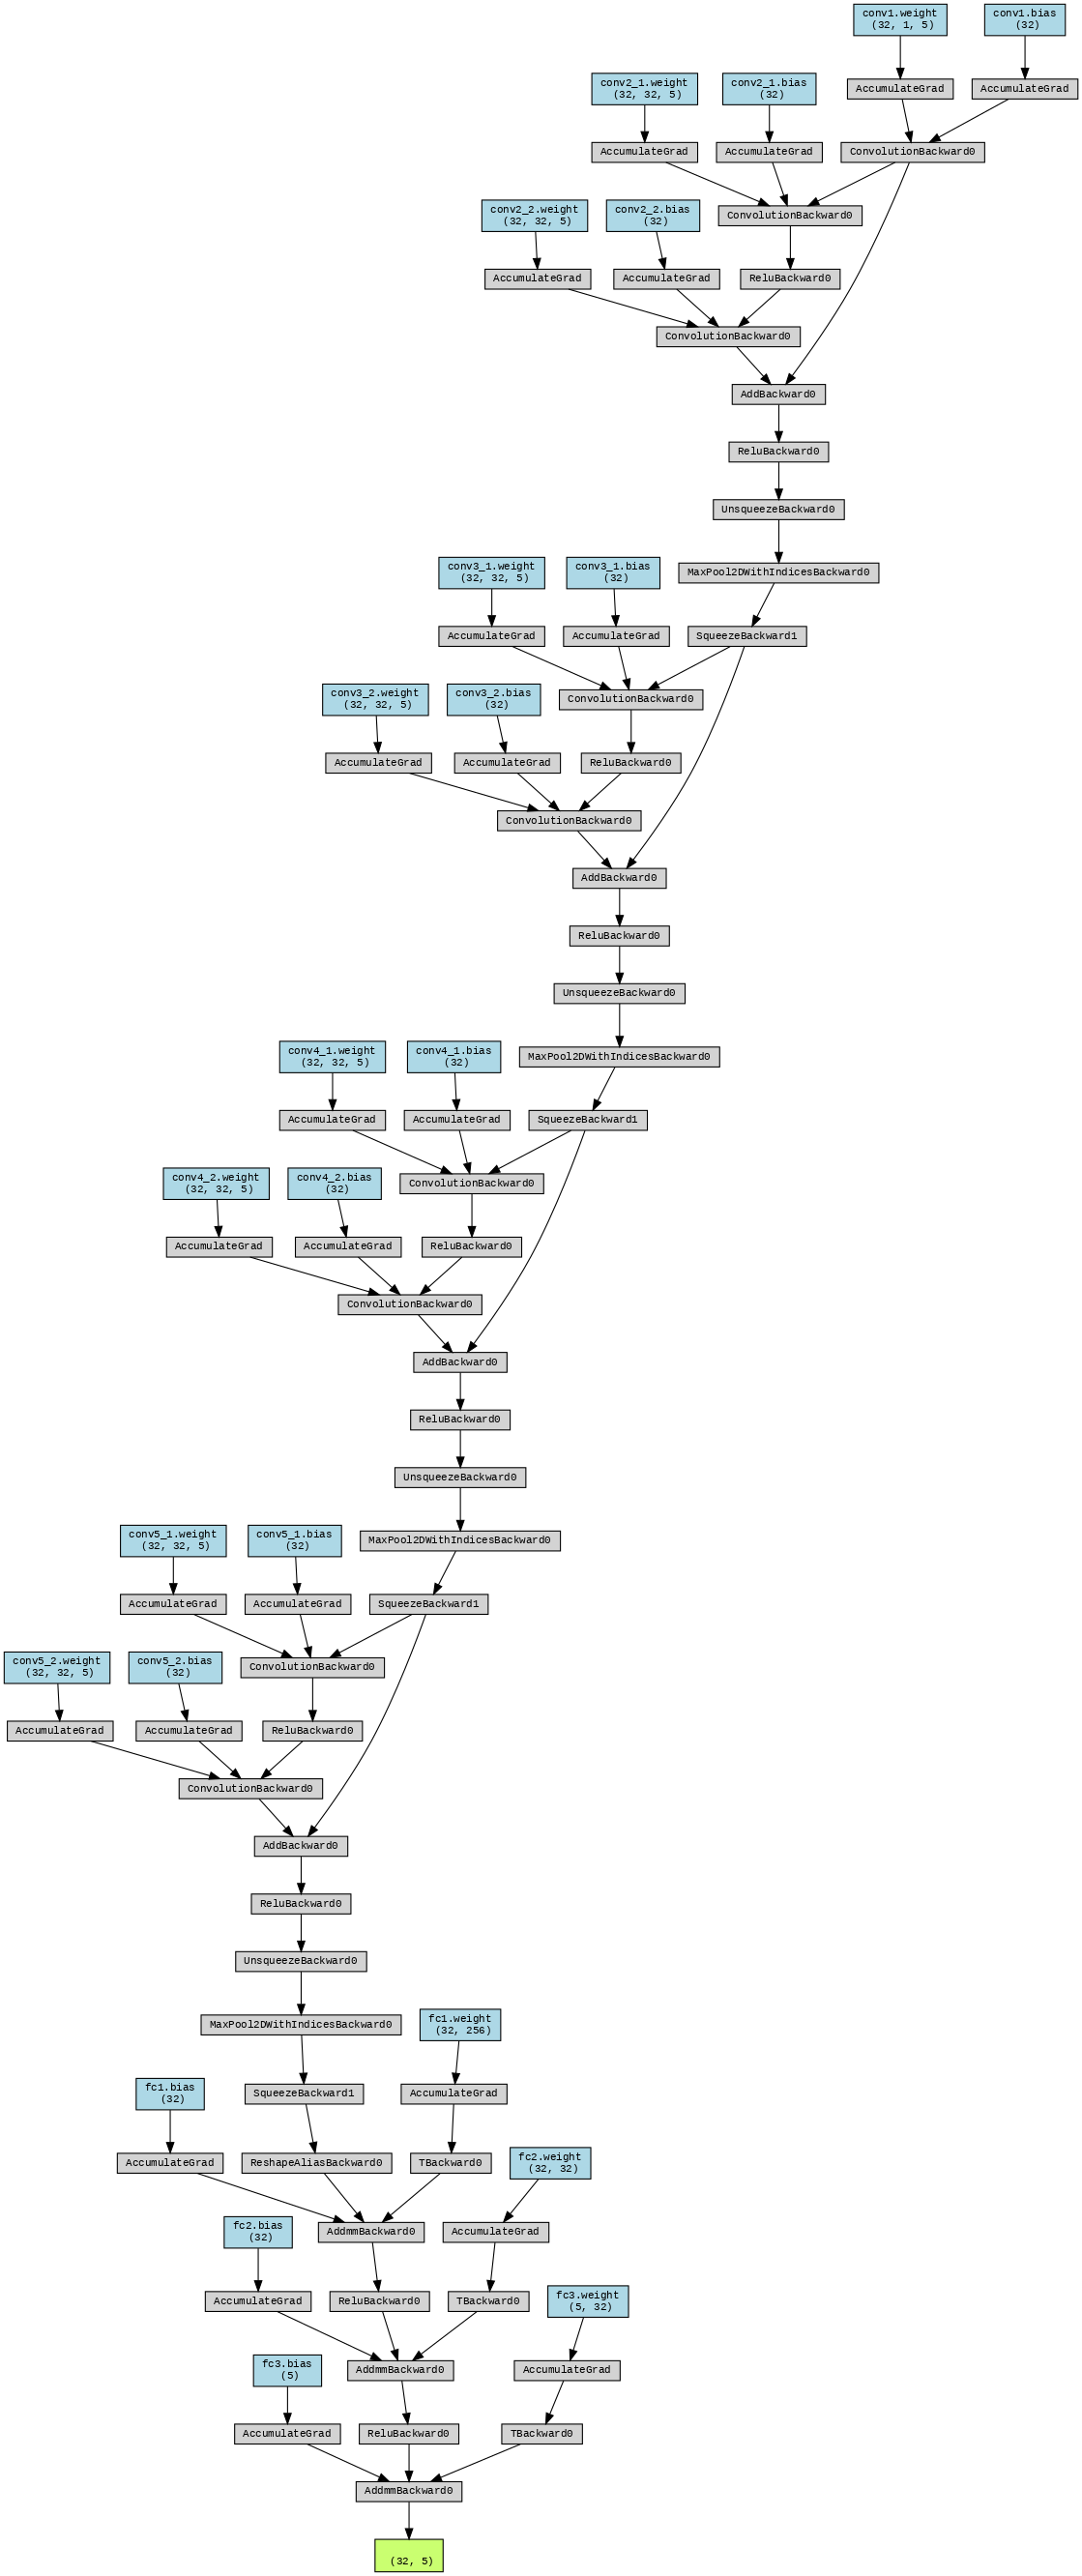

In [ ]:
import graphviz
from torchviz import make_dot
graphviz.set_jupyter_format('png')

# Create a dummy input tensor with the correct input size
input_tensor = torch.randn(32, 1, 187)

# Run the model with the input tensor, storing the output in a variable
output = model(input_tensor)

# Visualize the model graph using torchviz
make_dot(output, params=dict(model.named_parameters()))

## Check the weighted F1 score of the test set

In [ ]:
class_weights_normalized = get_weighted_for_ce(y_train)
criterion = nn.CrossEntropyLoss(weight=class_weights_normalized.to(device))

train_loader, val_loader, test_loader = get_loader(train_set, val_set, test_set, train_batch_size=64)
test_loss, test_acc, test_recall,test_precision,test_f1 = eval_epoch(model, criterion, test_loader)

In [ ]:
print(f' weight recall score of the best model on test set is {test_recall : .4f}')
print(f' weight precision score of the best model on test set is {test_precision : .4f}')
print(f' weight f1 score of the best model on test set is {test_f1 : .4f}')

 weight recall score of the best model on test set is  0.9794
 weight precision score of the best model on test set is  0.9963
 weight f1 score of the best model on test set is  0.9876


In [ ]:
# Update test score
benchmark.iloc[28,-3:] = [test_recall, test_precision, test_f1]

In [ ]:
benchmark.iloc[[0,28]]

,model_name,hyperparameter,best_epoch,best_train_cost,best_val_cost,best_train_recall,best_train_precision,best_train_f1,best_val_recall,best_val_precision,best_val_f1,best_test_recall,best_test_precision,best_test_f1
0,zero_baseline,seed=42,1,NaN,NaN,0.827732,0.685140,0.749716,0.827722,0.685123,0.749702,0.827608,0.684935,0.749543
28,deep_rescnn,"{'weight_decay': 0.01, 'learning_rate': 0.0006...",71,0.104476,1.420522,0.987573,0.993976,0.990042,0.980218,0.982213,0.980881,0.979353,0.996322,0.987624


Clearly, we can see that our best model is surpass the performance compared to the zero baseline. This indicate that our training is success



In [ ]:
#benchmark.to_csv('/content/drive/MyDrive/arrhythmia_classification/benchmark.csv',index=False)

## Confusion matrix

In [ ]:
# Confusion matrix plotter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_plotter(model,loader,set_name = 'train'):

    preds_all = []
    targets_all = []

    model.eval()
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            target = torch.argmax(target, dim=1)

            output = model(data)
            output = F.softmax(output, dim=1)
            _, preds = torch.max(output, 1)

            # append preds of each batch
            preds_all.append(preds)
            targets_all.append(target)


    preds_all = torch.cat(preds_all, dim=0)
    targets_all = torch.cat(targets_all, dim=0)

    conf_mat = confusion_matrix(targets_all.data.cpu().numpy(), preds_all.cpu().numpy())
    class_total = np.sum(conf_mat, axis=1)
    conf_mat_percent = conf_mat / class_total[:, np.newaxis] * 100

    fig, ax = plt.subplots(figsize=(8, 6))
    heatmap = sns.heatmap(conf_mat_percent, annot=True, fmt='.2f',
                      xticklabels=['N (0)', 'S (1)', 'V (2)', 'F (3)', 'Q (4)'], 
                      yticklabels=['N (0)', 'S (1)', 'V (2)', 'F (3)', 'Q (4)'],
                      cmap="Blues")
    cbar = heatmap.collections[0].colorbar
    cbar.set_label('Percentage (%)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion matrix of {set_name} set')
    plt.show()

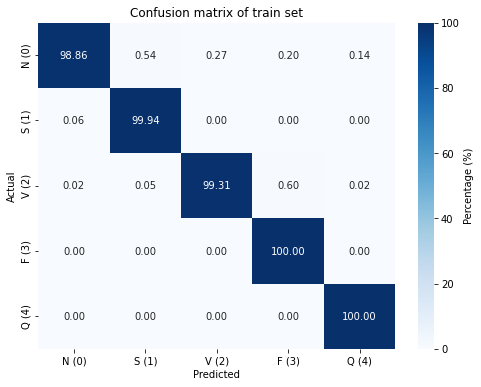

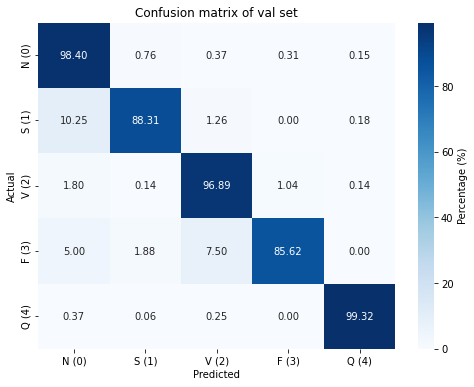

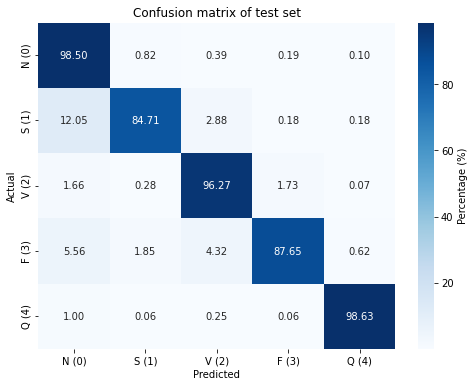

In [ ]:
for set_,loader_ in zip(['train','val','test'],[train_loader,val_loader,test_loader]):
    cm_plotter(model,loader_, set_)
    print('\n')

Recall that

| Key | Category | Annotations |
| --- | --- | --- |
| 0 | N | Normal |
| 1 | S | Supra-ventricular premature |
| 2 | V | Ventricular escape |
| 3 | F | Fusion of ventricular and normal |
| 4| Q | Unclassifiable |


According to the following confusion matrix, it seems like the model is overfitting to the class F (3), sicne the score on the training set is 100% correct, while on both val and test set is not exceed 90. The reason behind this might be the number of samples for this class is extremely low, so the model cannot do well. In future, it is a good idea to increase more data on this class, so we can improve the performance of the model

What's also share in the common for val and test set is that
1. the model often predicts S as Normal (~10%)
1. the model often predicts F as Normal (~5%)
1. the model often predicts F as V (~ุุ6%) [the pattern of them might be too similar)

Hopefully, this confusion matrix can give us the direction of how could we improve in the next phrase.

## Demonstration of prediction

Demonstrate how the output of each of test set

**The range of test set **

class 0 (normal): start - 18117

Class 1 (supra): 18118 - 18673 

Class 2 (ventracular) : 18674 - 20121

Class 3 (Fusion + Normal) : 20122 - 20283

Class 4 (Fusion + Normal) : 20284 - end

Demonstrate how to predict the input from each set, and also some random generated input with does not satisfy the shape (1,1,187)

In [ ]:
map_dct = {0:'normal',
           1:'Supra-ventricular premature',
           2:'Ventricular escape',
           3:'Fusion of ventricular and normal',
           4:'unclassifiable'}

def predict(model, data, map_dct = map_dct):
    model.eval()
    with torch.no_grad():
        output = model(data)
        prob = F.softmax(output, dim=1)
        pred = torch.argmax(prob, dim=1)
        pred = map_dct[pred.item()]
        prob = prob.max()

    return prob, pred

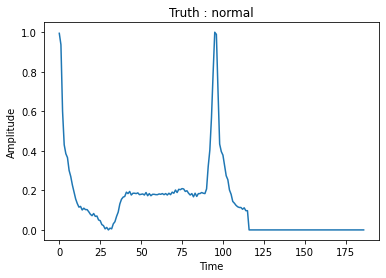

predict this as class normal with probability 0.9998453855514526


In [ ]:
index = 0 #@param {type:"slider", min:0, max:2909, step:1}
set_ = val_set #@param ["train_set", "val_set", "test_set"] {type:"raw"}

def predict_on_set(index,set_ = set_, map_dct = map_dct):

    data = set_[index]

    # X
    X = data[0].to(device)

    # Y_t
    target = data[1].argmax().item()
    target = map_dct[target]

    plt.plot(X.cpu()[0])
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title(f"Truth : {target}")
    plt.show()

    # Y_pred
    prob, pred = predict(model,X.unsqueeze(0))
    print(f'predict this as class {pred} with probability {prob}')

# Try predict
predict_on_set(index)



---



Next, we can predict on the generated data which may or may not have the same shape

In [ ]:
def preprocess(X,fix_seq_len = 187):
    """
    Fill to make the input tensor satisfy with tensor shape (1,1,187) bu padding or truncate (last)
    """
    seq_len = X.shape[2]

    if seq_len < fix_seq_len:
        diff = fix_seq_len - seq_len
        X = torch.nn.functional.pad(X, (0, diff)) #pad the sample

    elif seq_len > fix_seq_len:
        X = X[:, :, :fix_seq_len] # truncate-last on the sample
    
    assert X.shape == (1,1,187)
    return X

In [ ]:
import random

def predict_unknown(data=None):
    if data is None:
        random_len = random.randrange(1,187)
        data = torch.rand(1,1,random_len)

    processed_data = preprocess(data)
    processed_data = processed_data.to(device)

    plt.plot(processed_data.cpu()[0][0],color="red")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title(f"Truth : unknown")
    plt.show()

    prob, pred = predict(model,processed_data)
    print(f'predict this as class {pred} with probability {prob}')

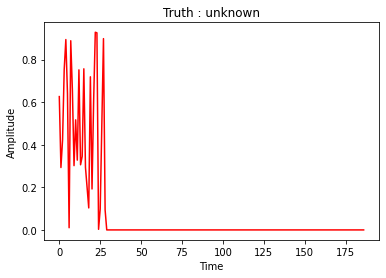

predict this as class normal with probability 0.8956060409545898


In [ ]:
# Try random
# Always expect positive, sine it is unusual to have this fluctuate
predict_unknown()

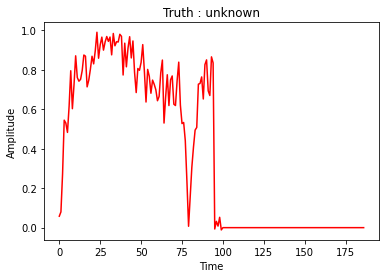

predict this as class Supra-ventricular premature with probability 0.9786847233772278


In [ ]:
x = test_set[100][0]
x = x[:,:100] # random cut the first 100 timestep

std = 0.02
noise = torch.randn(x.shape) * std
noisy_x = x + noise

# Try on noisy real data
predict_unknown(noisy_x.unsqueeze(0))

# ⏭ Deployment

The deployment of the trained model can have significant business impact in the medical field, particularly in the early detection and diagnosis of arrhythmia. By integrating the model into a system that connects with an ECG heartbeat pulse detector, the system can quickly classify ECG signals and provide early alerts for patients who have abnormal heart rhythms.

To ensure the accuracy and reliability of the system, it will undergo thorough review and testing by medical professionals before being deployed in a clinical setting. By deploying this system, healthcare providers can potentially reduce the number of patients who suffer from undetected arrhythmia, leading to better health outcomes and potentially saving lives.

Furthermore, the model can also potentially reduce healthcare costs by minimizing the need for invasive procedures and hospitalizations, as early detection and treatment can prevent the progression of arrhythmia to more severe conditions. Overall, the deployment of this model has the potential to significantly improve patient outcomes and enhance the efficiency of healthcare delivery.

However, since we don't have those hardwares, and we may need to test a quick deployment, we can do as the following

![](https://i.imgur.com/KggnB1x.png)

This is my proposal for deploying the project in real-life, despite my limitations in obtaining the actual ECG heart signal. Instead, I plan to develop a Flask API server that can receive data from an ECG machine, and then notify the patient's caregiver, doctor, or nurse. Although I won't be able to perform preprocessing in real-time, I will assume that the data has already been preprocessed as outlined in the research paper (with the exception of zero-padding) which involves approximately 7 steps.


The Flask API is hosted here : https://ecg-heartbeat-ai.onrender.com

The repository which set up the api can be found here : https://github.com/saranpan/ECG-Heartbeat-classifier


There are 2 ways to obtain the output given the heartbeat signal data: POST and GET.

Although POST is more efficient, but for simplicity, I am also going to demonstrate using GET method too

## GET Method

![](https://github.com/saranpan/ECG-Heartbeat-classifier/raw/main/images/demonstrate_AR.gif?raw=true)

( Not a typical heartbeat signal due to too short heartbeat sequence, but this is for a simplicity )

Suppose you have a heartbeat signal with length 149 timestep (already preprocessed), you can type like the following pattern : 
`https://ecg-heartbeat-ai.onrender.com/predict?beat_input=[1,0.9642248749732971,...,0.26575809717178345]`

lazy to type ? just go to this [link](https://ecg-heartbeat-ai.onrender.com/predict?beat_input=[1.0,0.9642248749732971,0.7614991664886475,0.4906303286552429,0.2674616575241089,0.13287904858589172,0.061328791081905365,0.047700170427560806,0.030664395540952682,0.03407154977321625,0.05110732465982437,0.0528109036386013,0.0528109036386013,0.05962521210312843,0.063032366335392,0.0528109036386013,0.05621805787086487,0.0528109036386013,0.04429301619529724,0.03577512875199318,0.03747870400547981,0.02214650809764862,0.015332197770476341,0.020442930981516838,0.015332197770476341,0.0,0.003407154930755496,0.013628619723021984,0.013628619723021984,0.011925042606890202,0.027257239446043968,0.030664395540952682,0.04429301619529724,0.047700170427560806,0.06643952429294586,0.07666099071502686,0.09028960764408112,0.10902895778417587,0.12776830792427063,0.13969334959983826,0.14821124076843262,0.17035774886608124,0.17546848952770233,0.1737648993730545,0.19080068171024323,0.19080068171024323,0.18228279054164886,0.17717206478118896,0.19761499762535095,0.18568995594978333,0.18739353120326996,0.19080068171024323,0.19080068171024323,0.1890971064567566,0.19591140747070312,0.20442929863929749,0.20613287389278412,0.20102214813232422,0.20954003930091858,0.20102214813232422,0.20102214813232422,0.19931857287883759,0.20613287389278412,0.20102214813232422,0.20613287389278412,0.20783644914627075,0.2112436145544052,0.20783644914627075,0.20783644914627075,0.20954003930091858,0.2112436145544052,0.20102214813232422,0.20613287389278412,0.21294718980789185,0.2112436145544052,0.20102214813232422,0.20954003930091858,0.20783644914627075,0.20272572338581085,0.20613287389278412,0.22316865622997284,0.21465076506137848,0.20783644914627075,0.20954003930091858,0.21976150572299957,0.20613287389278412,0.2112436145544052,0.21805791556835175,0.21805791556835175,0.20783644914627075,0.21976150572299957,0.21465076506137848,0.21294718980789185,0.20442929863929749,0.2163543403148651,0.21976150572299957,0.22487223148345947,0.22316865622997284,0.23850084841251373,0.24531516432762146,0.24872231483459473,0.24531516432762146,0.2538330554962158,0.24020442366600037,0.23339012265205383,0.2214650809764862,0.21805791556835175,0.20272572338581085,0.20272572338581085,0.19761499762535095,0.18739353120326996,0.1737648993730545,0.18228279054164886,0.1788756400346756,0.1686541736125946,0.17206132411956787,0.1890971064567566,0.19250425696372986,0.20102214813232422,0.20783644914627075,0.21294718980789185,0.20783644914627075,0.21805791556835175,0.22316865622997284,0.2163543403148651,0.21976150572299957,0.22487223148345947,0.21294718980789185,0.18057921528816223,0.14821124076843262,0.1788756400346756,0.2214650809764862,0.25553661584854126,0.34582623839378357,0.4991482198238373,0.48040884733200073,0.36456558108329773,0.2793866991996765,0.24872231483459473,0.24361158907413483,0.24020442366600037,0.2367972731590271,0.2538330554962158,0.24531516432762146,0.25042590498924255,0.252129465341568,0.2589437961578369,0.2538330554962158,0.26575809717178345])


When you click this link, you will be redirected to the output which is in form of dictionary like

`{"Class":"Ventricular escape","Probability":0.999957799911499}`

## POST Method

Since it's hard to read due to too long sequence, you can use POST method shown as the following

In [2]:
# I know it's painful to see this data
# This data is one of the data in the test set (which have its label as Ventricular escape)

beat_input = [1.0,0.9642248749732971,0.7614991664886475,0.4906303286552429,0.2674616575241089,
              0.13287904858589172,0.061328791081905365,0.047700170427560806,0.030664395540952682,
              0.03407154977321625,0.05110732465982437,0.0528109036386013,0.0528109036386013,0.05962521210312843,
              0.063032366335392,0.0528109036386013,0.05621805787086487,0.0528109036386013,0.04429301619529724,
              0.03577512875199318,0.03747870400547981,0.02214650809764862,0.015332197770476341,0.020442930981516838,
              0.015332197770476341,0.0,0.003407154930755496,0.013628619723021984,0.013628619723021984,0.011925042606890202,
              0.027257239446043968,0.030664395540952682,0.04429301619529724,0.047700170427560806,0.06643952429294586,
              0.07666099071502686,0.09028960764408112,0.10902895778417587,0.12776830792427063,0.13969334959983826,
              0.14821124076843262,0.17035774886608124,0.17546848952770233,0.1737648993730545,0.19080068171024323,
              0.19080068171024323,0.18228279054164886,0.17717206478118896,0.19761499762535095,0.18568995594978333,
              0.18739353120326996,0.19080068171024323,0.19080068171024323,0.1890971064567566,0.19591140747070312,
              0.20442929863929749,0.20613287389278412,0.20102214813232422,0.20954003930091858,0.20102214813232422,
              0.20102214813232422,0.19931857287883759,0.20613287389278412,0.20102214813232422,0.20613287389278412,
              0.20783644914627075,0.2112436145544052,0.20783644914627075,0.20783644914627075,0.20954003930091858,
              0.2112436145544052,0.20102214813232422,0.20613287389278412,0.21294718980789185,0.2112436145544052,
              0.20102214813232422,0.20954003930091858,0.20783644914627075,0.20272572338581085,0.20613287389278412,
              0.22316865622997284,0.21465076506137848,0.20783644914627075,0.20954003930091858,0.21976150572299957,
              0.20613287389278412,0.2112436145544052,0.21805791556835175,0.21805791556835175,0.20783644914627075,
              0.21976150572299957,0.21465076506137848,0.21294718980789185,0.20442929863929749,0.2163543403148651,
              0.21976150572299957,0.22487223148345947,0.22316865622997284,0.23850084841251373,0.24531516432762146,
              0.24872231483459473,0.24531516432762146,0.2538330554962158,0.24020442366600037,0.23339012265205383,
              0.2214650809764862,0.21805791556835175,0.20272572338581085,0.20272572338581085,0.19761499762535095,
              0.18739353120326996,0.1737648993730545,0.18228279054164886,0.1788756400346756,0.1686541736125946,
              0.17206132411956787,0.1890971064567566,0.19250425696372986,0.20102214813232422,0.20783644914627075,
              0.21294718980789185,0.20783644914627075,0.21805791556835175,0.22316865622997284,0.2163543403148651,
              0.21976150572299957,0.22487223148345947,0.21294718980789185,0.18057921528816223,0.14821124076843262,
              0.1788756400346756,0.2214650809764862,0.25553661584854126,0.34582623839378357,0.4991482198238373,
              0.48040884733200073,0.36456558108329773,0.2793866991996765,0.24872231483459473,0.24361158907413483,
              0.24020442366600037,0.2367972731590271,0.2538330554962158,0.24531516432762146,0.25042590498924255,
              0.252129465341568,0.2589437961578369,0.2538330554962158,0.26575809717178345]

In [23]:
# Demonstrate How to POST using Python
import requests

# Make sure to turn list into string first [0.1,0.12] -> '[0.1,0.12]'
url = 'https://ecg-heartbeat-ai.onrender.com/predict_ar'
input_json = {'beat_input': str(beat_input)}

x = requests.post(url, json = input_json)
print(x.text)

{"Class":"Ventricular escape","Probability":0.999957799911499}





---



That's it, this is how we can do to obtain the output given heartbeat signal sequence

I have a real test case for this task, which the data is actually from the test set, you can check out here : https://github.com/saranpan/ECG-Heartbeat-classifier/blob/main/real_test_case_ar.txt, at the end of the data, you will the actual label of that